<a href="https://colab.research.google.com/github/Sjing2/SJ_project/blob/master/%5B%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%20%EB%94%A5%EB%9F%AC%EB%8B%9D%20%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8%5DCycle%20GAN%EC%9D%84%20%ED%99%9C%EC%9A%A9%ED%95%9C%20%EB%A9%94%EC%9D%B4%ED%81%AC%EC%97%85%20%EC%9D%B4%EB%AF%B8%EC%A7%80%20%EC%83%9D%EC%84%B1%20%EB%AA%A8%EB%8D%B8%20%EA%B5%AC%ED%98%84/%5B%EC%A0%84%EC%B2%98%EB%A6%AC%5D_Align_Face_%ED%99%9C%EC%9A%A9(%EC%96%BC%EA%B5%B4_%EC%9D%B8%EC%8B%9D%2C_%EC%A0%84%EC%B2%98%EB%A6%AC_%EC%8B%9C%EA%B0%81%ED%99%94).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#드라이브 mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import dlib
import matplotlib.patches as patches
import tensorflow as tf
import cv2
import gc
import os

# Align Face + 전처리
크롤링 파일 한 군데에 몰아넣기
- [크롤링]화장 전후
- [크롤링]화장 전
- [크롤링]화장 후

In [ ]:
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('/content/drive/My Drive/[github] 프로젝트 코드 정리/머신러닝/shape_predictor_5_face_landmarks.dat')

def align_faces(img):
    dets = detector(img, 1)
    objs = dlib.full_object_detections()
    for detection in dets:
        s = sp(img, detection)
        objs.append(s)
    faces = dlib.get_face_chips(img, objs, size=150, padding=0.35) # original size=256
    return faces

def add_blank(image):
    height = image.shape[0]
    width = image.shape[1]
    square = np.zeros((max(height, width), max(height, width), 3))
    if height > width:
        square[:, (height-width)//2:(height-width)//2 + width, :] = image
    else:
        square[(width-height)//2:(width-height)//2 + height, :, :] = image
    return square

path_dir = ['/content/drive/My Drive/[github] 프로젝트 코드 정리/머신러닝/[크롤링]화장 전후']

file_before_after = os.listdir(path_dir[0])

before = np.zeros((len(file_before_after), 150, 150, 3))
after = np.zeros((len(file_before_after), 150, 150, 3))

# 1. 화장 전 후 사진 쪼개기
for i, file in enumerate(file_before_after):
    img = dlib.load_rgb_image(path_dir[0]+ '/' + file)

    n_half = img.shape[1] // 2
    bef = img[:,:n_half,:]
    aft = img[:,n_half:,:]
    try:
        before[i,:] = align_faces(bef)[0]
    except RuntimeError: # 얼굴 인식 안되는 경우 align 과정 거치지 않고 기본 전처리만 진행
        bef = add_blank(bef)
        bef = cv2.resize(bef, (150, 150))
        before[i,:] = bef
    try:
        after[i,:] = align_faces(aft)[0]
    except RuntimeError:
        aft = add_blank(aft)
        aft = cv2.resize(aft, (150, 150))
        after[i,:] = aft

# 2. 화장 전 단독 사진 before에 이어서 추가
for i, file in enumerate(file_before):
    img = dlib.load_rgb_image(path_dir[1]+ '/' + file)
    try:
        before[i + len(file_before_after),:] = align_faces(img)[0]
    except RuntimeError:
        img = add_blank(img)
        img = cv2.resize(img, (150, 150))
        before[i + len(file_before_after),:] = img

# 3. 화장 후 단독 사진 after에 이어서 추가
for i, file in enumerate(file_after):
    img = dlib.load_rgb_image(path_dir[2] + '/' + file)
    try:
        after[i + len(file_before_after),:] = align_faces(img)[0]
    except RuntimeError:
        img = add_blank(img)
        img = cv2.resize(img, (150, 150))
        after[i + len(file_before_after),:] = img

before, after = before.astype(np.uint8), after.astype(np.uint8)

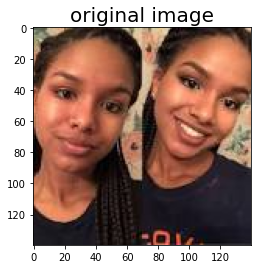

In [ ]:
image = dlib.load_rgb_image('/content/drive/My Drive/[github] 프로젝트 코드 정리/머신러닝/[크롤링]makeup before after/101.jpg')
plt.title("original image", size=20)
plt.imshow(image)

In [ ]:
n_half = image.shape[1] // 2
bef = image[:,:n_half,:]
aft = image[:,n_half:,:]

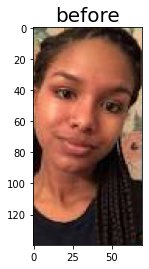

In [ ]:
plt.title('before', size=20)
plt.imshow(bef)

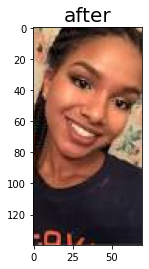

In [ ]:
plt.title('after', size=20)
plt.imshow(aft)

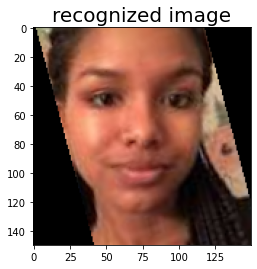

In [ ]:
plt.title('recognized image', size=20)
plt.imshow(align_faces(bef)[0])

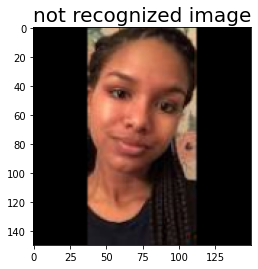

In [ ]:
bef2 = add_blank(bef)
bef2 = cv2.resize(bef2, (150, 150))
plt.title('not recognized image', size=20)
plt.imshow(bef2.astype(int))

In [ ]:
before.shape, after.shape

((74, 150, 150, 3), (76, 150, 150, 3))

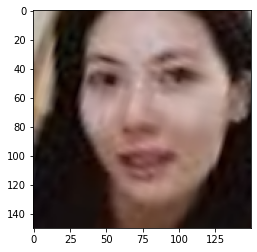

In [ ]:
plt.imshow(before[-1,:])

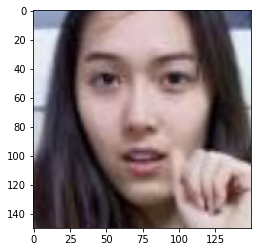

In [ ]:
plt.imshow(after[-1,:])

In [ ]:
# 화장 전 후 쪼갠 사진 시각화
def makeup_before_after(number):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(before[number,:])
    ax[0].set_title('before')
    ax[1].imshow(after[number,:])
    ax[1].set_title('after')

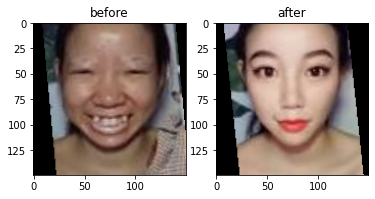

In [ ]:
makeup_before_after(0) # 얼굴 인식 잘 된 경우

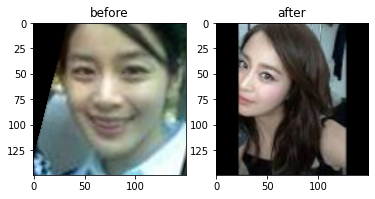

In [ ]:
makeup_before_after(5) # 얼굴 인식 after가 안 된 경우

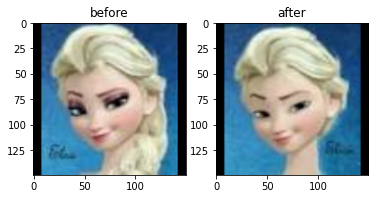

In [ ]:
makeup_before_after(34) # 얼굴 인식 둘 다 안 된 경우(순서도 바뀜)

# Align Face 시각화(참고용)

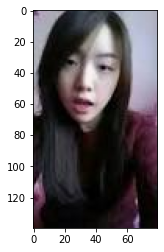

In [ ]:
img = dlib.load_rgb_image('/content/drive/My Drive/[github] 프로젝트 코드 정리/머신러닝/[크롤링]화장 전후/11.jpg')
n_half = img.shape[1] // 2
before = img[:,:n_half,:]
after = img[:,n_half:,:]
plt.imshow(before)

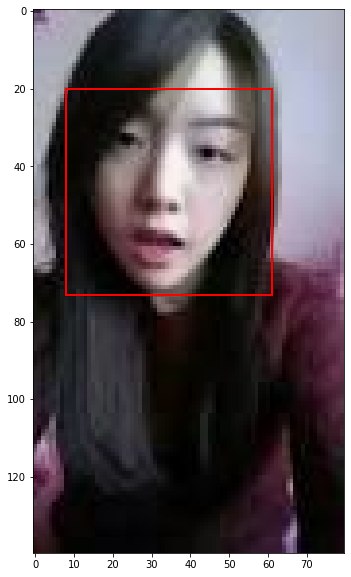

In [ ]:
img_result = before.copy()
dets = detector(before, 1)

if len(dets) == 0:
    print('cannot find faces!')
fig, ax = plt.subplots(1, figsize=(16, 10))
for det in dets:
    x, y, w, h = det.left(), det.top(), det.width(), det.height()

    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.imshow(img_result)

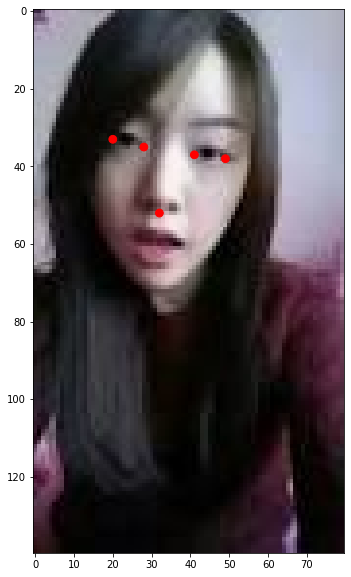

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 10))

objs = dlib.full_object_detections()

for detection in dets:
    s = sp(img, detection)
    objs.append(s)
    
    for point in s.parts():
        circle = patches.Circle((point.x, point.y), radius=1, edgecolor='r', facecolor='r')
        ax.add_patch(circle)

ax.imshow(img_result)

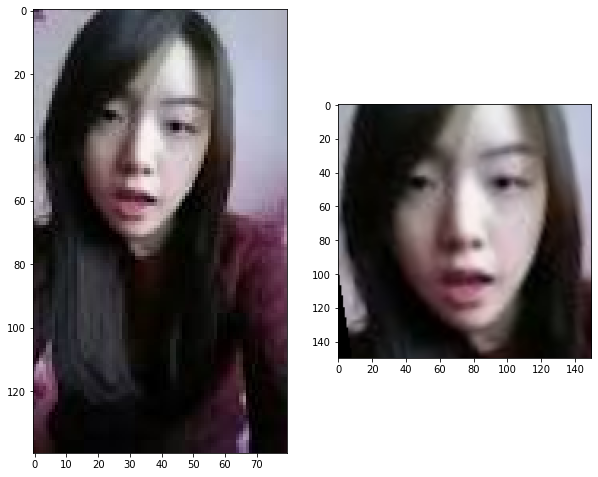

In [ ]:
faces = dlib.get_face_chips(img, objs, size=150, padding=0.3)
fig, axes = plt.subplots(1, len(faces)+1, figsize=(10, 10))
axes[0].imshow(before)
for i, face in enumerate(faces):
    axes[i+1].imshow(face)

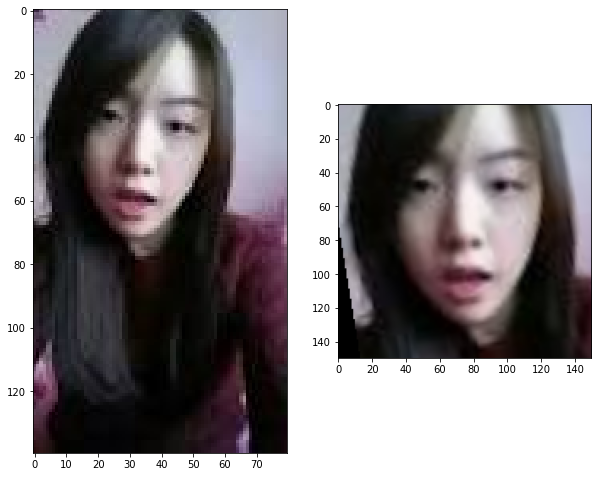

In [ ]:
def align_faces(img):
    dets = detector(img, 1)
    objs = dlib.full_object_detections()
    for detection in dets:
        s = sp(img, detection)
        objs.append(s)
    faces = dlib.get_face_chips(img, objs, size=150, padding=0.35) # size=256
    return faces

test_img = before
test_faces = align_faces(test_img)

fig, axes = plt.subplots(1, len(test_faces)+1, figsize=(10, 10))
axes[0].imshow(test_img)

for i, face in enumerate(test_faces):
    axes[i+1].imshow(face)

In [ ]:
def preprocess(img):
    return img.astype(np.float32) / 127.5 - 1.

def postprocess(img):
    return ((img + 1.) * 127.5).astype(np.uint8)